# This spread sheet uses surface temperaturue measurements along with Other met and canopy variables and estimates of Rn G to give estimates of ET and compares with measurements

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import MathsUtilities as MUte
import GraphHelpers as GH

## Bring in data

### Bring in the cover Data

Text(0,0.5,'Cover Green')

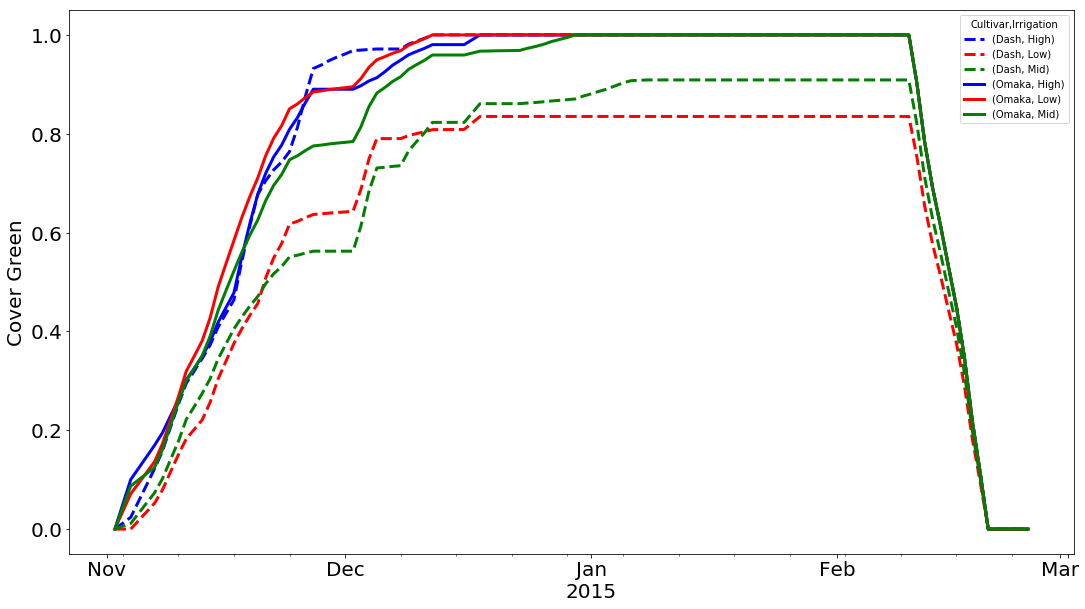

In [2]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

Text(0,0.5,'Cover Green')

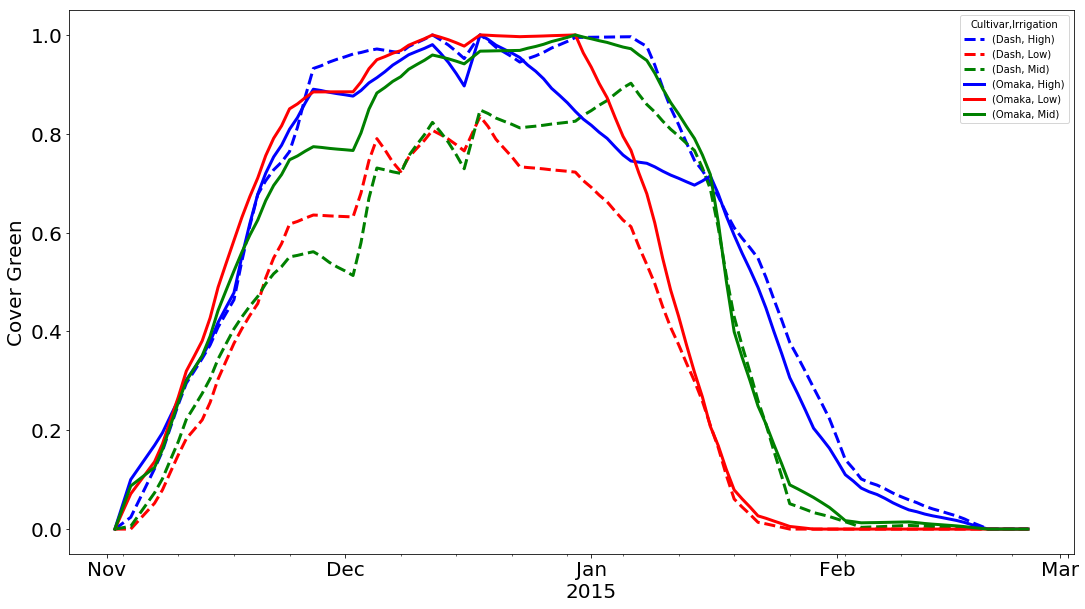

In [3]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

Text(0,0.5,'Height')

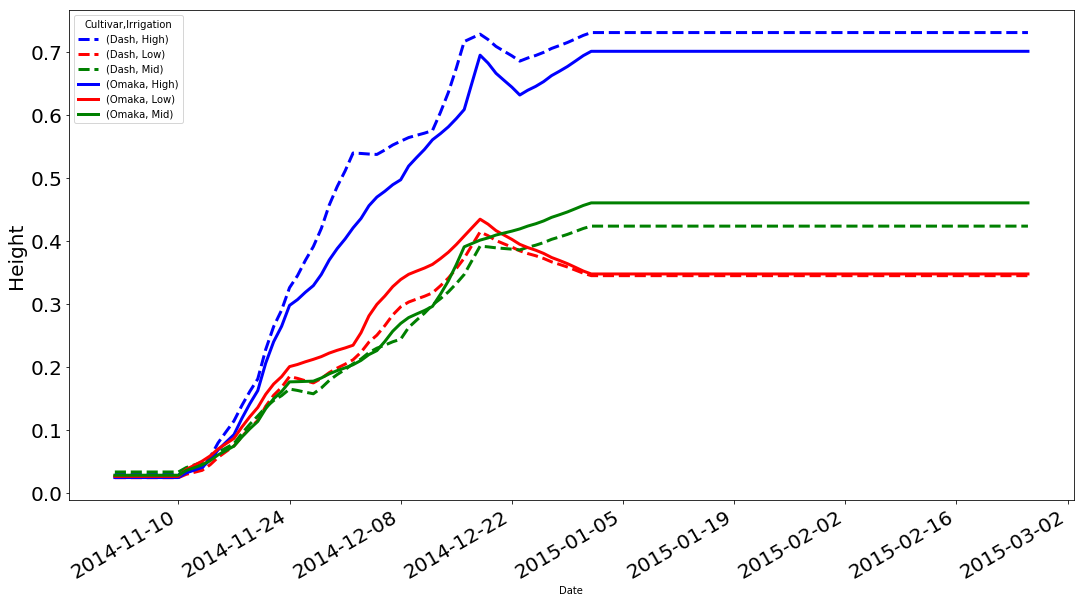

In [4]:
HeightData = pd.read_pickle('.\DataFrames\HeightEstimated.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Height', fontsize = 20)

In [5]:
GPs = GH.SetGraphicsPatterns(CoverData.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Cultivar
['Dash', 'Omaka']
Irrigation
['High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Dash', 'Omaka'], ['High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('--', 'blue', 0.45, '^'), ('--', 'red', 0.45, '^'), ('--', 'green', 0.45, '^'), ('-', 'blue', 0.15, 'o'), ('-', 'red', 0.15, 'o'), ('-', 'green', 0.15, 'o')]
StyleFrame
           Lin    Col   Alp Mar    MFC
Dash  High  --   blue  0.45   ^   blue
      Low   --    red  0.45   ^    red
      Mid   --  green  0.45   ^  green
Omaka High   -   blue  0.15   o  white
      Low    -    red  0.15   o  white
      Mid    -  green  0.15   o  white


## Bring in the Energy Balance Data

In [6]:
EstRn = pd.read_pickle('.\DataFrames\EstNetRadiation.pkl')
EstG= pd.read_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
TnRData.index.name='Date'
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
TsULTa = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
ECT = '2014-11-08 00:00:00'
LCT = '2015-02-11 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
#D=1200
D0 = 4000
T0 = 6
E1 = -0.00015
E0 = -0.0005
E = -0.0005
C1 = 1.2
C0 = 2
CB = 0.6
##Contract dataframes down to common index size
TnRData = TnRData.loc[ECT:LCT,:]

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

## Do some processing and cleaning

In [7]:
#Create a list of time to exclude where data was missing or irrigation was applied
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']

ExclusionDates = IrrigationDates
for Date in NoMeasurementDates:
    ExclusionDates.append(Date)

#Exclude data from Temperature and radiation dataframe
ExclusionDateTimes5 = []
for Date in ExclusionDates:
    ExclusionDateTimes5 += pd.date_range(Date,periods=288,freq='5T')
TnRData = TnRData.loc[~TnRData.index.isin(ExclusionDateTimes5)]

# Make an index of all daylight hours in trial
HourlyTnRDataSum = TnRData.resample('h').sum()
HourlyTnRDataMean = TnRData.resample('h').mean()
DaylightIndex = HourlyTnRDataSum.loc[:,'IncomingRadnMJ'].where(HourlyTnRDataSum.loc[:,'IncomingRadnMJ']>0.02)
DaylightIndex.dropna(inplace=True)
DaylightIndex = pd.to_datetime(DaylightIndex.index)

# Make day time means and sums for temperature and radiation data
DayTimeTnRDataMean = HourlyTnRDataMean.loc[DaylightIndex].resample('d').mean()
DayTimeTnRDataSum = HourlyTnRDataSum.loc[DaylightIndex].resample('d').sum()

# Make daily (day time) ET dataframe from hourly data excluding dark periods
ET = HourlyWateruse.loc[DaylightIndex].resample('d').sum()
ET = ET.loc[~ET.index.isin(ExclusionDates)]
ET = ET*-1
ET.index.name = 'Date'

#Exclude non measurement and irrigation dates from Rn and G data frames
EstRn = EstRn.loc[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.loc[~EstG.index.isin(ExclusionDates)]

#Exclude data from Surface Temperature upper limit dataframe and make daily mean
TsULTa = TsULTa.loc[~TsULTa.index.isin(ExclusionDateTimes5)]
HourlyTsULTa = TsULTa.resample('h').mean()
DayTimeTsULTaMean = TsULTa.loc[DaylightIndex].resample('d').mean()

In [8]:
def makeSeries(Var,Frame):
    SSeries= Frame.loc[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [9]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.loc[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.loc[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Make surface temperature limit data long and join into energy balance data frame
DayTimeTsULTaMean.index.name = 'Date'
TsULTaLong = DayTimeTsULTaMean.unstack()
TsULTaLong.name = 'TsUL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsULTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.loc[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.reindex(DateSet).unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
VPSeries = makeSeries('VP',TnRDataLong)
for plot in PlotList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    EstEnergyBalance.loc[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.loc[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.loc[plot,'u'] = windSeries.values
    EstEnergyBalance.loc[plot,'q'] = qSeries.values
    EstEnergyBalance.loc[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.loc[plot,'Ea'] = VPSeries.values
    EstEnergyBalance.loc[plot,'PET'] = DayTimePET[EstEnergyBalance.loc[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.loc[:,'Cover'] = CoverData.loc[DateSet].bfill().unstack()
EstEnergyBalance.loc[:,'GreenCover'] = GreenCoverData.reindex(DateSet).bfill().unstack()
EstEnergyBalance.loc[:,'Height'] = HeightData.reindex(DateSet).bfill().unstack()
    
#Calculate some other values    
EstEnergyBalance.loc[:,'qCp'] = EstEnergyBalance.loc[:,'q'] * Cp
EstEnergyBalance.loc[:,'uVPD'] = EstEnergyBalance.loc[:,'u'] * EstEnergyBalance.loc[:,'VPD']
EstEnergyBalance.loc[:,'Ts-TaqCp'] = EstEnergyBalance.loc[:,'Ts-Ta'] * EstEnergyBalance.loc[:,'q'] * Cp
EstEnergyBalance.loc[:,'EstRn-EstG'] = EstEnergyBalance.loc[:,'EstRn'] - EstEnergyBalance.loc[:,'EstG']

EstEnergyBalance.loc[:,'Ts'] = EstEnergyBalance.loc[:,'Ta'] + EstEnergyBalance.loc[:,'Ts-Ta']
EstEnergyBalance.loc[:,'To'] = EstEnergyBalance.loc[:,'Ts']  + 0 + EstEnergyBalance.loc[:,'VPD'] * 1
EstEnergyBalance.loc[:,'To-Ta'] =  EstEnergyBalance.loc[:,'To'] -  EstEnergyBalance.loc[:,'Ta'] 

EstEnergyBalance.loc[:,'TsUL'] = EstEnergyBalance.loc[:,'Ta'] + EstEnergyBalance.loc[:,'TsUL-Ta']
EstEnergyBalance.loc[:,'ToUL'] = EstEnergyBalance.loc[:,'TsUL'] + 0 +  EstEnergyBalance.loc[:,'VPD'] * 1
EstEnergyBalance.loc[:,'ToUL-Ta'] = EstEnergyBalance.loc[:,'ToUL'] - EstEnergyBalance.loc[:,'Ta']
EstEnergyBalance.loc[:,'(To-Ta)/(ToUL-Ta)'] = EstEnergyBalance.loc[:,'To-Ta']/EstEnergyBalance.loc[:,'ToUL-Ta']
EstEnergyBalance.loc[:,'(To-Ta)qCp'] = EstEnergyBalance.loc[:,'To-Ta'] * EstEnergyBalance.loc[:,'qCp']

IntIndex = range(EstEnergyBalance.index.size)
EstEnergyBalance.loc[:,'EqEvap'] = [et.Priestly_TaylorEO(EstEnergyBalance.loc[x,'EstRn-EstG'],EstEnergyBalance.loc[x,'Ta'],1,'net') for x in EstEnergyBalance.index]
EstEnergyBalance.loc[:,'PenEvap'] = [et.PenmanEO(EstEnergyBalance.loc[x,'EstRn-EstG'],EstEnergyBalance.loc[x,'Ta'],EstEnergyBalance.loc[x,'u'],EstEnergyBalance.loc[x,'Ea'],'net') for x in EstEnergyBalance.index]
EstEnergyBalance.loc[:,'Rn/Ta'] = EstEnergyBalance.loc[:,'EstRn']/EstEnergyBalance.loc[:,'Ta']

#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)

EstEnergyBalance.loc[:,'A'] = EstEnergyBalance.loc[:,'ET']/EstEnergyBalance.loc[:,'EqEvap']
EstEnergyBalance.loc[:,'1/A'] = 1/EstEnergyBalance.loc[:,'A']
EstEnergyBalance.loc[:,'LnA'] = np.log(EstEnergyBalance.loc[:,'A'])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log


In [10]:
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


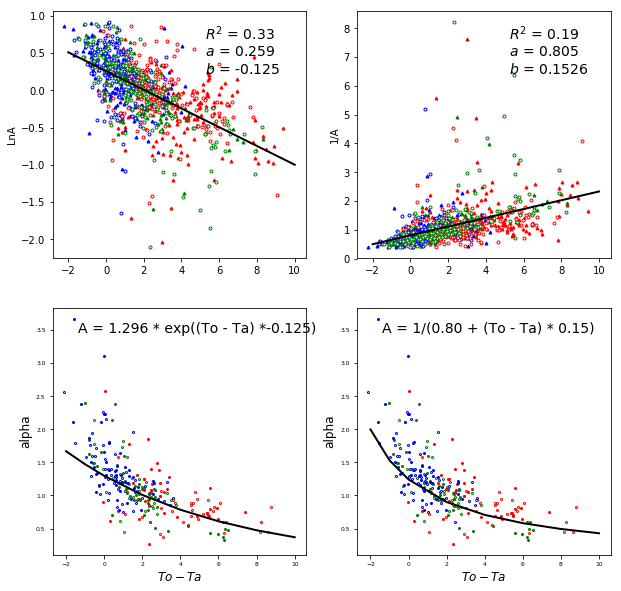

In [12]:
CoverFilter = EstEnergyBalance.loc[:,'GreenCover'] > 0.6
HighCoverIndex = EstEnergyBalance.index[CoverFilter]
FittingData = EstEnergyBalance.reindex(HighCoverIndex).reindex(['A','Ts-Ta','VPD','To-Ta','LnA','1/A'],axis=1)
FittingData.loc[:,'LnA'] = FittingData.loc[:,'LnA'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'LnA'] = FittingData.loc[:,'LnA'].where(FittingData.loc[:,'A']>0.1,np.nan)
FittingData.loc[:,'1/A'] = FittingData.loc[:,'1/A'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'1/A'] = FittingData.loc[:,'1/A'].where(FittingData.loc[:,'A']>0.1,np.nan)
FittingData.loc[:,'A'] = FittingData.loc[:,'A'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'A'] = FittingData.loc[:,'A'].where(FittingData.loc[:,'A']>0.1,np.nan)

Graphs = plt.figure(figsize=(10,10))
pos=1
for mod in ['LnA','1/A']:
    CoverFilter = EstEnergyBalance.loc[:,'GreenCover'] > 0.6
    ax = Graphs.add_subplot(2,2,pos)
    GH.AddIndexedXY(FittingData.loc[:,'To-Ta'].unstack().transpose(),
        FittingData.loc[:,mod].unstack().transpose(),
                    ax,GPs,3)
    ax = Graphs.add_subplot(2,2,pos)
    Y = FittingData.loc[CoverFilter,mod]
    X = FittingData.loc[CoverFilter,'To-Ta']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
    Ys = []
    for x in Xs:
        Ys.append(RegStats.Intercept + x*RegStats.Slope)
    plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
       
    fitR2 = '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:5]\
    + '\n$b$ = ' + str(RegStats.Slope)[:6] 
    plt.text(0.6,.75,fitR2,fontsize=14,transform=ax.transAxes) 
    plt.ylabel(mod)
    
    ax = Graphs.add_subplot(2,2,pos+2)
    Colors = ['red', 'green', 'blue']
    Markerfills = ['white','white','white','red', 'green', 'blue']
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigations:
            CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.6
            Y = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
            X = EBMeans.loc[(cul,irr),'To-Ta'].loc[CoverFilter]
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=1,ms=2)
            irrpos+=1
            culpos+=1
    Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
    Ys = []
    for x in Xs:
        if mod == 'LnA':
            Ys.append(np.exp(RegStats.Intercept) * np.exp(x*RegStats.Slope))
            equ = 'A = ' + str(np.exp(RegStats.Intercept))[:5] + ' * exp((To - Ta) *' + str(RegStats.Slope)[:6] + ')'
        if mod == '1/A':
            Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
            equ = fitR2 = 'A = 1/(' + str(RegStats.Intercept)[:4] + ' + (To - Ta) * ' + str(RegStats.Slope)[:4] + ')'
    plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
    plt.text(0.1,.9,equ,fontsize=14,transform=ax.transAxes) 
    plt.ylabel('alpha', fontsize = 12)
    plt.xlabel('$To-Ta$',fontsize = 12)
    plt.tick_params(labelsize =6)
    pos+=1


# The stuff below here is a mess.  Please ignore

In [ ]:
CoverFilter = EstEnergyBalance.loc[:,'GreenCover'] > 0.6

HighCoverIndex = EstEnergyBalance.index[CoverFilter]
FittingData = EstEnergyBalance.reindex(HighCoverIndex).reindex(['A','Ts-Ta','VPD','To-Ta','LnA'],axis=1)
FittingData.loc[:,'LnA'] = FittingData.loc[:,'LnA'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'LnA'] = FittingData.loc[:,'LnA'].where(FittingData.loc[:,'A']>0.1,np.nan)
FittingData.loc[:,'A'] = FittingData.loc[:,'A'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'A'] = FittingData.loc[:,'A'].where(FittingData.loc[:,'A']>0.1,np.nan)

Graphs = plt.figure(figsize=(8,8))
ax = Graphs.add_subplot(1,1,1)
GH.AddIndexedXY(FittingData.loc[:,'To-Ta'].unstack().transpose(),
    FittingData.LnA.unstack().transpose(),
                ax,GPs,10)

Y = FittingData.loc[CoverFilter,'LnA']
X = FittingData.loc[CoverFilter,'To-Ta']
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(RegStats.Intercept + x*RegStats.Slope)
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')

fitR2 = r'$\alpha = a + b(T_o-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:5]\
    + '\n$b$ = ' + str(RegStats.Slope)[:6] 
plt.text(7,.5,fitR2,fontsize=14) 

In [ ]:
RegStats.Intercept

In [ ]:
RegStats.Slope

In [ ]:
EstEnergyBalance.loc[:,'FitA'] = [np.exp(RegStats.Intercept) * np.exp(EstEnergyBalance.loc[x,'To-Ta']*RegStats.Slope) for x in EstEnergyBalance.index]
EstEnergyBalance.loc[:,'Aresid'] = EstEnergyBalance.loc[:,'A'] - EstEnergyBalance.loc[:,'FitA']
EstEnergyBalance.loc[:,'AresidRel'] = EstEnergyBalance.loc[:,'A'] / EstEnergyBalance.loc[:,'FitA']

EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (10,10))
#Comparison = plt.figure(figsize = (5.6,5.6))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0
        Y = EBMeans.loc[(cul,irr),'AresidRel'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'GreenCover'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,0.6,1]   
y = [0.1,1,1]
plt.plot(x,y, linewidth = 3)
plt.ylabel('Kc', fontsize = 7)
plt.xlabel('$NDVI_{corrected}$',fontsize = 7)
plt.tick_params(labelsize =6)

Comparison.savefig('Kc.jpg',dpi=1000)

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (10,10))
#Comparison = plt.figure(figsize = (5.6,5.6))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'To-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(np.exp(RegStats.Intercept) * np.exp(x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
RegStats.Intercept + x*RegStats.Slope
plt.ylabel('/alpha', fontsize = 7)
plt.xlabel('$To-Ta$',fontsize = 7)
plt.tick_params(labelsize =6)

In [ ]:
EBMeans.columns

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (10,10))
#Comparison = plt.figure(figsize = (5.6,5.6))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.6
        Y = EBMeans.loc[(cul,irr),'AresidRel'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'Rn/Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1

In [ ]:
Graphs = plt.figure(figsize=(8,8))
ax = Graphs.add_subplot(1,1,1)
GH.AddIndexedPlot(EBMeans.AresidRel.unstack().transpose().loc['2014-12-17':'2014-12-23',:],
                ax,GPs,2)


In [ ]:
Graphs = plt.figure(figsize=(8,8))
ax = Graphs.add_subplot(1,1,1)
GH.AddIndexedPlot(EBMeans.EqEvap.unstack().transpose().loc['2014-12-17':'2014-12-23',:],
                ax,GPs,2)


In [ ]:
Graphs = plt.figure(figsize=(8,8))
ax = Graphs.add_subplot(1,1,1)
GH.AddIndexedPlot(EBMeans.EstRn.unstack().transpose().loc['2014-12-17':'2014-12-23',:],
                ax,GPs,2)


In [ ]:
EstRn = EstRn.loc[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.loc[~EstG.index.isin(ExclusionDates)]


In [ ]:
#Calculate evapotranspiration
#EstEnergyBalance.loc[:,'FitA'] = [1/(EstEnergyBalance.loc[x,'To-Ta']*0.182 + 0.6852) for x in IntIndex]
EstEnergyBalance.loc[:,'FitA'] = [np.exp(0.34) * np.exp(EstEnergyBalance.loc[x,'To-Ta']*-0.14) for x in EstEnergyBalance.index]
EstEnergyBalance.loc[:,'Aresid'] = EstEnergyBalance.loc[:,'A'] - EstEnergyBalance.loc[:,'FitA']
EstEnergyBalance.loc[:,'AresidRel'] = EstEnergyBalance.loc[:,'A'] / EstEnergyBalance.loc[:,'FitA']

EstEnergyBalance.loc[:,'FitATs'] = [1/(EstEnergyBalance.loc[x,'Ts-Ta']*0.1589 + 0.8656) for x in EstEnergyBalance.index]
EstEnergyBalance.loc[:,'AresidTs'] = EstEnergyBalance.loc[:,'A'] - EstEnergyBalance.loc[:,'FitATs']
EstEnergyBalance.loc[:,'AresidRelTs'] = EstEnergyBalance.loc[:,'A'] / EstEnergyBalance.loc[:,'FitATs']


GCov = [0,0.5,1]   
CovR = [-.7,0,0]
EstEnergyBalance.loc[:,'CoverResp'] = [np.interp(EstEnergyBalance.loc[x,'GreenCover'],GCov,CovR) for x in EstEnergyBalance.index]
EstEnergyBalance.loc[:,'Alpha'] = EstEnergyBalance.loc[:,'FitA'] + EstEnergyBalance.loc[:,'CoverResp']
EstEnergyBalance.loc[:,'EstET'] = [et.Priestly_TaylorEO(EstEnergyBalance.loc[x,'EstRn-EstG'],EstEnergyBalance.loc[x,'Ta'],EstEnergyBalance.loc[x,'Alpha'],'net') for x in EstEnergyBalance.index]

#Calculate residual
EstEnergyBalance.loc[:,'ResidualET'] = EstEnergyBalance.loc[:,'ET'] - EstEnergyBalance.loc[:,'EstET']

#make a dataframe with treatment means
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.7
        Y = 1/EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'To-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
CoverFilter = EBMeans.loc[:,'GreenCover'] > 0.5
Y = 1/EBMeans.loc[:,'A'].loc[CoverFilter]
X = EBMeans.loc[:,'To-Ta'].loc[CoverFilter]
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
fig.text(X.min(),3,fitR2,fontsize=20)        
# x = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
# y = 1/np.divide(5.8,np.add(x,4.7))
# plt.plot(x,y)
#plt.ylim(0,5)
#Comparison.savefig('Fig110.jpg',dpi = 1000)
plt.ylabel(r'$1/\alpha$', fontsize=22)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 22)

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.7
        Y = np.log(EBMeans.loc[(cul,irr),'A'].loc[CoverFilter])
        X = EBMeans.loc[(cul,irr),'Ts-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
CoverFilter = EBMeans.loc[:,'GreenCover'] > 0.5
Y = np.log(EBMeans.loc[:,'A'].loc[CoverFilter])
X = EBMeans.loc[:,'Ts-Ta'].loc[CoverFilter]
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
fig.text(X.min(),3,fitR2,fontsize=20)        
# x = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
# y = 1/np.divide(5.8,np.add(x,4.7))
# plt.plot(x,y)
#plt.ylim(0,5)
#Comparison.savefig('Fig110.jpg',dpi = 1000)
plt.ylabel(r'$1/\alpha$', fontsize=22)
plt.xlabel(r'$(T_s-T_a)$',fontsize = 22)

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (3.6,8))
fig = Comparison.add_subplot(2,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'To-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],ms=3)
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.loc[:,'GreenCover'] > 0.5
Y = 1/EBMeans.loc[:,'A'].loc[CoverFilter]
X = EBMeans.loc[:,'To-Ta'].loc[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
#plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$1/\alpha = a + b(T_o-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:4]\
    + '\n$b$ = ' + str(RegStats.Slope)[:4] 
plt.text(4,3,fitR2,fontsize=7) 
plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=False,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=7)
plt.xlabel(r'$T_o-T_a\/\/(^oC)$',fontsize = 7)
plt.text(-3.7,3.8,'a',fontsize = 7)

# culpos = 0
# fig = Comparison.add_subplot(2,1,2)
# for cul in Cultivars:
#     irrpos = 0
#     for irr in Irrigations:
#         CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0
#         Y = EBMeans.loc[(cul,irr),'Aresid'].loc[CoverFilter]
#         X = EBMeans.loc[(cul,irr),'GreenCover'].loc[CoverFilter]
#         plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
#         irrpos+=1
#         culpos+=1
# x = [0,0.5,1]   
# y = [-.6,0,0]
# plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=6,length = 3, direction = 'out', pad = 1)
# plt.tick_params(axis='y', which='both', left=False,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
# plt.ylabel(r'$\alpha\ residuals$', fontsize=7)
# plt.xlabel(r'$Green Cover$',fontsize = 7)
# plt.plot(x,y,linewidth=2)
# fig.yaxis.labelpad = 0
# plt.text(0.03,1.35,'b',fontsize = 7)
Comparison.savefig('Fig_8.jpg',dpi = 1000)

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (8,6))
fig = Comparison.add_subplot(1,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'To-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.loc[:,'GreenCover'] > 0.5
Y = 1/EBMeans.loc[:,'A'].loc[CoverFilter]
X = EBMeans.loc[:,'To-Ta'].loc[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
#plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$1/\alpha = a + b(T_o-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:4]\
    + '\n$b$ = ' + str(RegStats.Slope)[:4] 
plt.text(3,2.5,fitR2,fontsize=24) 
plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=16,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=False,right=False, labelright=False,labelsize=16, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=22)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 22)

In [ ]:
RegStats

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (3.6,4))
fig = Comparison.add_subplot(1,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'To-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = (EBMeans.loc[:,'GreenCover'] > 0.6) 
Y = np.log(EBMeans.loc[:,'A'].loc[CoverFilter])
X = EBMeans.loc[:,'Ts-Ta'].loc[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
Exp = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
    #Exp.append(np.exp(0.3271)*np.exp(x*-.1362))
    Exp.append(1.4*np.exp(-0.14*x))
plt.plot(Xs,Exp,'-', linewidth = 2, color='k')
#fitR2 = r'$\alpha = e^a + e^{(T_o-T_a)*b} $'  \
fitR2 =  '\n$R^2$ = 0.57' # + str(RegStats.R2)[:4]\
    #+ '\n$p$ = ' + str(RegStats.Intercept)[:4]\
    #+ '\n$q$ = ' + str(-RegStats.Slope)[:4] 
plt.text(5,2.3,fitR2,fontsize=12) 
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=8,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=False,right=False, labelright=False,labelsize=8, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.xlabel(r'$(T_o-T_a)$',fontsize = 12)
plt.ylim(0,2.5)
Comparison.savefig('Fig_8.jpg',dpi = 1000)
Comparison.savefig('Fig_8.eps',dpi = 1000)

In [ ]:
np.exp(RegStats.Intercept+.1)

In [ ]:
RegStats.Slope

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (8,6))
fig = Comparison.add_subplot(1,1,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.5
        Y = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'Ts-Ta'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos])
        irrpos+=1
        culpos+=1
        
CoverFilter = EBMeans.loc[:,'GreenCover'] > 0.5
Y = 1/EBMeans.loc[:,'A'].loc[CoverFilter]
X = EBMeans.loc[:,'Ts-Ta'].loc[CoverFilter]
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
#plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$1/\alpha = a + b(T_s-T_a) $'  \
    + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$a$ = ' + str(RegStats.Intercept)[:4]\
    + '\n$b$ = ' + str(RegStats.Slope)[:4] 
plt.text(3,2.5,fitR2,fontsize=24) 
plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=16,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=False,right=False, labelright=False,labelsize=16, length = 3, direction = 'out', pad = 1)
plt.ylabel(r'$\alpha$', fontsize=22)
plt.xlabel(r'$(T_s-T_a)$',fontsize = 22)

In [ ]:
CoverFilter = EstEnergyBalance.loc[:,'GreenCover'] > 0.5
FittingData = EstEnergyBalance.loc[:,('A','1/A','Ts-Ta','VPD','To-Ta','LnA')].loc[CoverFilter]
FittingData.loc[:,'1/A'] = FittingData.loc[:,'1/A'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'1/A'] = FittingData.loc[:,'1/A'].where(FittingData.loc[:,'A']>0.1,np.nan)
FittingData.loc[:,'LnA'] = FittingData.loc[:,'LnA'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'LnA'] = FittingData.loc[:,'LnA'].where(FittingData.loc[:,'A']>0.1,np.nan)
FittingData.loc[:,'A'] = FittingData.loc[:,'A'].where(FittingData.loc[:,'A']<2.5,np.nan)
FittingData.loc[:,'A'] = FittingData.loc[:,'A'].where(FittingData.loc[:,'A']>0.1,np.nan)

In [ ]:
plt.plot(FittingData.loc[:,'To-Ta'],FittingData.loc[:,'A'],'o')
Xs = [-2,-1,0.0,2.0,4.0,6.0,8.0,10.0]   
Ys = []
Exp = []
for x in Xs:
    Ys.append(1/(RegStats.Intercept + x*RegStats.Slope))
    Exp.append(np.exp(0.3271)*np.exp(x*-.1362))
plt.plot(Xs,Ys,'-', linewidth = 2, color='k')
plt.plot(Xs,Exp,'--', linewidth = 2, color='k')
#plt.ylim(-1,10)

In [ ]:
plt.plot(FittingData.loc[:,'To-Ta'],FittingData.loc[:,'1/A'],'o')

In [ ]:
plt.plot(FittingData.loc[:,'To-Ta'],FittingData.loc[:,'LnA'],'o')

In [ ]:
Descriptors = ['To-Ta']
X = FittingData.loc[:,FittingData.columns.isin(Descriptors)]
Y = FittingData.loc[:,'LnA']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.7
        Y = EBMeans.loc[(cul,irr),'FitATs'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,3]   
y = [0,3]
plt.plot(x,y)

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        CoverFilter = EBMeans.loc[(cul,irr),'GreenCover'] > 0.7
        Y = EBMeans.loc[(cul,irr),'FitA'].loc[CoverFilter]
        X = EBMeans.loc[(cul,irr),'A'].loc[CoverFilter]
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
x = [0,3]   
y = [0,3]
plt.plot(x,y)

In [ ]:
EBMeans.loc[(cul,irr),'EstET'].loc['2014-11-16':'2015-01-15'].values

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.loc[(cul,irr),'ET'].loc['2014-11-16':'2015-01-15']
        X = EBMeans.loc[(cul,irr),'EstET'].loc['2014-11-16':'2015-01-15']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
#Make a binary filter to exclude High and Low reatments
ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
X = EBMeans.loc[ValidationFilter,'EstET'] 
Y = EBMeans.loc[ValidationFilter,'ET']
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
plt.plot(Xs,Ys,'-', linewidth = 4, color='g')
plt.plot([0,10],[0,10],'-', linewidth = 4, color='k')
fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
    + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
    + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
plt.text(8,1.,fitR2,fontsize=20)        
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
plt.xlabel(r'$ET_{Est}$ $(Using$ $T_s-T_a$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.text(-0.5,13,'a',fontsize=24)
plt.xlim(-1,14)
plt.ylim(-1,14)



fig = Comparison.add_subplot(2,2,2)
culpos = 0
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.loc[(cul,irr),'ET']
        #X = DayTimePET.loc[Y.index]
        X = EBMeans.loc[(cul,irr),'PET']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
plt.plot([0,12],[0,14.4],'-', linewidth = 4, color='k')
plt.xlabel('$PET$ $(Using$ $Penman$ $Monteith$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.ylim(-2,14)
plt.text(0.5,13,'b',fontsize=24)
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
#plt.legend(['Low Dash','Mid Dash','High Dash','Low Omaka','Mid Omaka','High Omaka'],loc=[-1.25,1.05],ncol=6,fontsize=18)
#plt.text(-8,16.5,'Irrigation level and cultivar treatments',fontsize=24)
plt.xlim(0,14)


fig = Comparison.add_subplot(2,2,3)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0 
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.loc[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.loc[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = EstEnergyBalance.loc[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean()
        plt.plot(xData,yData/yObs, 'o',  mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlabel('$T_s-T_a$ $(^oC)$',fontsize=20)
plt.tick_params(labelsize = 16)
plt.text(0.03,5.2,'c',fontsize=24)
plt.ylim(-6,6)
plt.plot([0,1],[0,0],'-', linewidth = 4, color='k')

fig = Comparison.add_subplot(2,2,4)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0  
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.loc[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.loc[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = yData.index
        plt.plot(xData,yData/yObs, 'o', mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
    plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlim('2014-11-1','2015-02-15')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=16)
plt.text('2014-11-4',1.6,'d',fontsize=24)
plt.ylim(-4,2)
plt.plot(['2014-11-1','2015-02-15'],[0,0],'-', linewidth = 4, color='k')

In [ ]:
MakeCumGraph()

In [ ]:
def MakeCumGraph():
    graph = plt.figure(figsize=(18,10))
    start = '2014-11-16'
    end = '2015-03-15'
    pos = 1
    for Irr in Irrigations:
        line = '-'
        for Cul in Cultivars:
            Pannel = graph.add_subplot(3,2,pos)    
            Data = EBMeans.loc[(Cul,Irr),:]
            plt.plot(Data.loc[start:end,'ET'].cumsum(),label = 'ET',linewidth = 2)
            plt.plot(Data.loc[start:end,'EstET'].cumsum(),label = 'EstET',linewidth = 2)
            #plt.plot(Data.loc[start:end,'PenEvap'].cumsum(),label='PenEvap',linewidth = 2)
            #plt.plot(Data.loc[start:end,'PrystTay'].cumsum(),label='PrystlyT',linewidth = 2)
            #plt.plot(Data.loc[start:end,'PenMon'].cumsum(),label='PenMon',linewidth = 2)
            diff = Data.loc[start:end,'EstET'].cumsum() - Data.loc[start:end,'ET'].cumsum()
            plt.plot(diff,linewidth = 2)
            plt.ylim(-50,400)
            plt.text('2014-11-15',350,Irr + ' ' + Cul,fontsize=16)
            line = '--'
            if pos == 1:
                plt.legend(loc=1)
            pos +=1

In [ ]:
EstEnergyBalance.PotET